In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import shap

pd.set_option("display.max_columns", 100)
sns.set(style="whitegrid")

In [2]:
df = pd.read_csv("../data/features.csv", parse_dates=["date"])
df.head()

,id,title,content,date,label,hour,dayofweek,is_weekend,content_length,num_exclamations,num_questions,num_uppercase_words,num_links,num_hashtags,keyword_hits,sentiment_score
0,1,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,2017-12-31,1,0.0,6.0,1,2893,6,9,5,0,0,2,-0.8681
1,2,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,2017-12-31,1,0.0,6.0,1,1898,0,0,3,0,0,0,-0.7141
2,3,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",2017-12-30,1,0.0,5.0,1,3597,2,4,42,1,3,2,-0.9953
3,4,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",2017-12-29,1,0.0,4.0,0,2774,0,1,5,4,0,0,-0.9176
4,5,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,2017-12-25,1,0.0,0.0,0,2346,0,0,0,0,0,0,0.3134


df["label"].value_counts().plot(kind="bar", color=["green", "red"])
plt.title("Label Distribution")
plt.xticks([0, 1], labels=["Real (0)", "Fake (1)"], rotation=0)
plt.ylabel("Count")
plt.show()

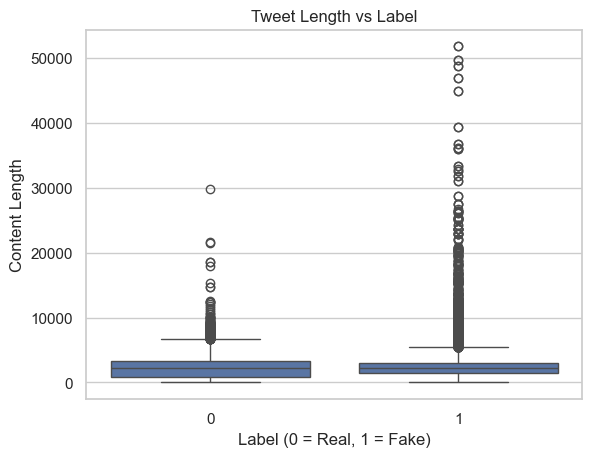

In [3]:
sns.boxplot(data=df, x="label", y="content_length")
plt.title("Tweet Length vs Label")
plt.xlabel("Label (0 = Real, 1 = Fake)")
plt.ylabel("Content Length")
plt.show()

In [4]:
features = [
    "hour", "dayofweek", "is_weekend",
    "content_length", "num_exclamations", "num_questions",
    "num_uppercase_words", "num_links", "num_hashtags", "keyword_hits"
]

X = df[features]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      4284
           1       0.90      0.93      0.92      4696

    accuracy                           0.91      8980
   macro avg       0.91      0.91      0.91      8980
weighted avg       0.91      0.91      0.91      8980



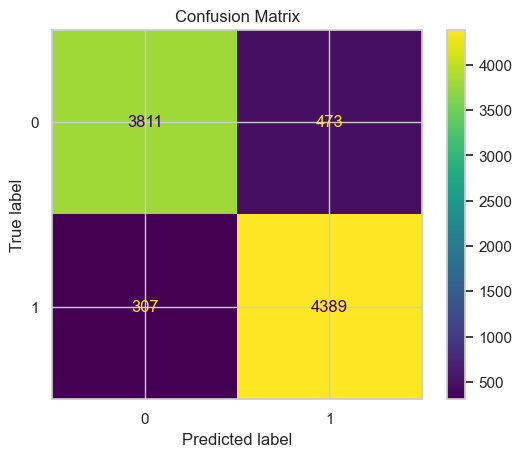

In [5]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion Matrix")
plt.show()

In [6]:
import shap
import time
import matplotlib.pyplot as plt

print("Starting SHAP computation...")

sample = X_test.sample(n=100, random_state=42)

start = time.time()
explainer = shap.Explainer(rf, sample)
shap_values = explainer(sample)
end = time.time()

print(f"SHAP computation completed in {end - start:.2f} seconds.")


Starting SHAP computation...
SHAP computation completed in 8.45 seconds.


SHAP summary plot saved.


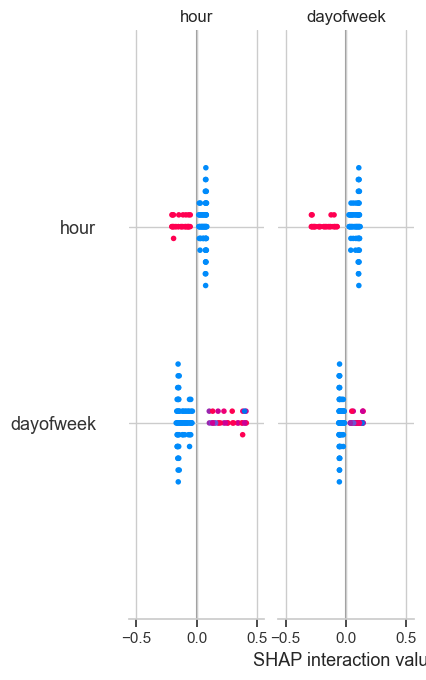

In [7]:
shap.summary_plot(shap_values, sample, show=False)
fig = plt.gcf()
fig.savefig("shap_summary.png", bbox_inches="tight")
print("SHAP summary plot saved.")


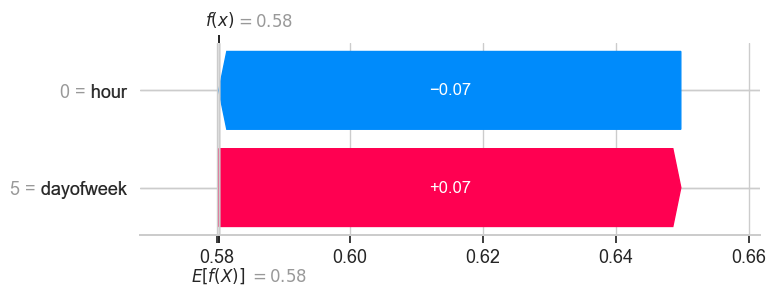

In [8]:
explanation = shap.Explanation(
    values=shap_values.values[0, 1],
    base_values=shap_values.base_values[0, 1],
    data=shap_values.data[0],
    feature_names=shap_values.feature_names
)

shap.plots.waterfall(explanation)
